In [ ]:
import numpy as np
import pandas as pd
import time
import tracemalloc
from numpy.linalg import norm, eigvals
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm
from functools import wraps

In [40]:
def make_A_b(n, dtype, k=7, m=4):
    A = np.empty((n, n), dtype=dtype)
    for i in range(n):
        for j in range(n):
            A[i, j] = k if i == j else 1.0 / (abs((i + 1) - (j + 1)) + m)
    return A

In [ ]:
times = {}
mems  = {}

def timed_jacobi(fn):
    @wraps(fn)
    def inner(A, b, x0, tol, maxiter, criterion, case, n, dtype_name, x0_name, tol_value):
        tracemalloc.start()
        t0 = time.perf_counter()
        x, iters = fn(A.astype(getattr(np, dtype_name)), 
                      b.astype(getattr(np, dtype_name)), 
                      x0.astype(getattr(np, dtype_name)), 
                      tol, maxiter, criterion)
        dt = time.perf_counter() - t0
        _, peak = tracemalloc.get_traced_memory()
        tracemalloc.stop()

        key = (case, n, dtype_name, x0_name, criterion, tol_value)
        times[key] = dt
        mems[key]  = peak
        return x, iters
    return inner

@timed_jacobi
def jacobi_solver(A, b, x0, tol=1e-8, maxiter=5000, criterion='diff'):
    D = np.diag(A)
    R = A - np.diagflat(D)
    x_old = x0.copy()
    for k in range(1, maxiter + 1):
        x_new = (b - R @ x_old) / D
        if criterion == 'diff' and norm(x_new - x_old, ord=np.inf) < tol:
            return x_new, k
        if criterion == 'res' and norm(A @ x_new - b, ord=np.inf) < tol:
            return x_new, k
        x_old = x_new
    return x_old, maxiter + 1 # maxiter + 1 pokaże, że nie osiągnięto zbieżności

In [42]:
def compute_spectral_radius(A):
    D = np.diag(A)
    R = A - np.diagflat(D)
    B = -R / D[:, None]
    eigs = eigvals(B)
    return np.max(np.abs(eigs))

In [ ]:
def run_experiments(ns, dtypes, cases, criteria, tolerances, maxiter=5000, k=7, m=4):
    records = []
    spectral = []

    for case in cases:
        for n in ns:
            print("running case n:", n)

            for dtype_name in dtypes:
                A = make_A_b(n, getattr(np, dtype_name), k, m)

                rho = compute_spectral_radius(A)
                spectral.append({
                    'case': case,
                    'n': n,
                    'dtype': dtype_name,
                    'rho': rho
                })

                # Generujemy wektor x_true jako losową permutację z {1, -1}
                perm = np.random.permutation(n)
                half = n // 2
                x_true_vals = np.concatenate([np.ones(half), -np.ones(n - half)])
                x_true = x_true_vals[perm].astype(getattr(np, dtype_name))

                b = A @ x_true

                # Definicja trzech wektorów początkowych:
                # 1) wektor zerowy
                x0_zero = np.zeros(n, dtype=getattr(np, dtype_name))
                # 2) wektor losowany z wyboru {-100, 100}
                x0_100 = np.random.choice([100.0, -100.0], size=n).astype(getattr(np, dtype_name))
                # 3) wektor losowany z wyboru {±30, ±40, ±50, ±60}
                choices_mid = [30.0, -30.0, 40.0, -40.0, 50.0, -50.0, 60.0, -60.0]
                x0_mid = np.random.choice(choices_mid, size=n).astype(getattr(np, dtype_name))

                x0_list = [
                    (x0_zero, "zero"),
                    (x0_100, "rand100"),
                    (x0_mid,  "rand_mid")
                ]

                for x0, x0_name in x0_list:
                    for criterion in criteria:
                        for tol in tolerances:
                            x_approx, iters = jacobi_solver(
                                A, b, x0, tol, maxiter, criterion,
                                case, n, dtype_name, x0_name, tol
                            )
                            err_inf = norm(x_true - x_approx, ord=np.inf)
                            err2    = norm(x_true - x_approx, ord=2)
                            key = (case, n, dtype_name, x0_name, criterion, tol)
                            t    = times[key]
                            mem  = mems[key]
                            avg_time = t / iters if iters > 0 else np.nan
                            records.append({
                                "x0_name":        x0_name,
                                "case":           case,
                                "criterion":      criterion,
                                "tol":            tol,
                                "n":              n,
                                "dtype":          dtype_name,
                                "iters":          iters,
                                "time":           t,
                                "mem":            mem,
                                "avg_time_iter":  avg_time,
                                "err_inf":        err_inf,
                                "err2":           err2,
                                "rho":            rho
                            })

    df_jacobi   = pd.DataFrame.from_records(records)
    df_spectral = pd.DataFrame.from_records(spectral)
    return df_jacobi, df_spectral

In [ ]:
if __name__ == '__main__':
    np.random.seed(0)

    ns = [3,5,10,20,30,40,50,100,200,300,400,500]
    dtypes = ['float64']
    cases = ['b']
    criteria = ['diff', 'res']
    tolerances = [1e-2, 1e-3, 1e-5, 1e-7, 1e-9, 1e-12, 1e-15]
    
    df_jacobi, df_spectral = run_experiments(ns, dtypes, cases, criteria, tolerances, maxiter=5000)

    df_spectral.to_csv('spectral_radii.csv', index=False)

    df_zero    = df_jacobi[df_jacobi['x0_name'] == 'zero']
    df_rand100 = df_jacobi[df_jacobi['x0_name'] == 'rand100']
    df_mid     = df_jacobi[df_jacobi['x0_name'] == 'rand_mid']

    df_zero.to_csv('jacobi_zero.csv',       index=False)
    df_rand100.to_csv('jacobi_rand100.csv',  index=False)
    df_mid.to_csv('jacobi_rand_mid.csv',     index=False)

running case n: 3
running case n: 5
running case n: 10
running case n: 20
running case n: 30
running case n: 40
running case n: 50
running case n: 100
running case n: 200
running case n: 300
running case n: 400
running case n: 500


In [ ]:
def run_experiment_2():
    ns = list(range(300, 401))
    dtype = np.float64

    records = []
    for n in ns:
        A = make_A_b(n, dtype)
        rho = compute_spectral_radius(A)
        records.append({'n': n, 'rho': rho})

    df_rho = pd.DataFrame(records)
    df_rho.sort_values('n', inplace=True)

    # Znalezienie pierwszego n, dla którego rho >= 1
    mask_not_conv = df_rho['rho'] >= 1.0
    if mask_not_conv.any():
        n_first_not_conv = int(df_rho[mask_not_conv].iloc[0]['n'])
    else:
        n_first_not_conv = None

    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df_rho, x='n', y='rho', marker='o', label='ρ(A)')
    plt.axhline(1.0, color='gray', linestyle='--', label='ρ = 1')

    if n_first_not_conv is not None:
        plt.axvline(n_first_not_conv, color='red', linestyle='--',
                    label=f'Pierwsze n, gdzie ρ ≥ 1: {n_first_not_conv}')

    plt.xlabel('Rozmiar układu (n)')
    plt.ylabel('Promień spektralny ρ')
    plt.title('Promień spektralny ρ (300 ≤ n ≤ 400)')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return df_rho

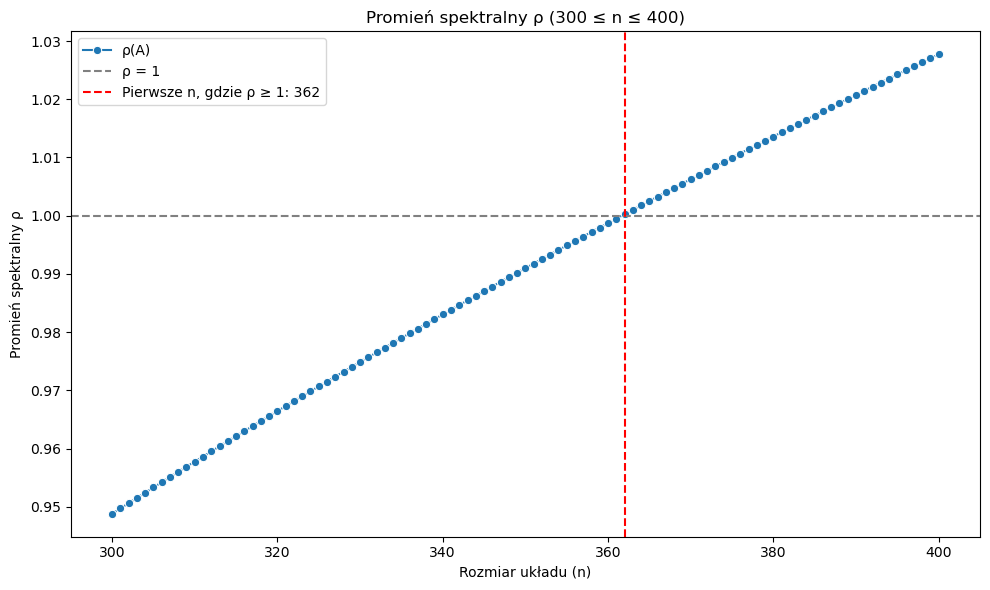

In [ ]:
if __name__ == '__main__':
    df_rho_res = run_experiment_2()
    df_rho_res.to_csv('experiment2_spectral_radii.csv', index=False)

In [ ]:
def run_experiment_3():
    ns = list(range(1, 1001))
    dtype = np.float64

    records = []
    for n in ns:
        A = make_A_b(n, dtype)
        rho = compute_spectral_radius(A)
        records.append({'n': n, 'rho': rho})

    df_rho = pd.DataFrame(records)
    df_rho.sort_values('n', inplace=True)

    mask_not_conv = df_rho['rho'] >= 1.0
    if mask_not_conv.any():
        n_first_not_conv = int(df_rho[mask_not_conv].iloc[0]['n'])
    else:
        n_first_not_conv = None

    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df_rho, x='n', y='rho', marker='o', label='ρ(A)')
    plt.axhline(1.0, color='gray', linestyle='--', label='ρ = 1')

    if n_first_not_conv is not None:
        plt.axvline(n_first_not_conv, color='red', linestyle='--',
                    label=f'Pierwsze n, gdzie ρ ≥ 1: {n_first_not_conv}')

    plt.xlabel('Rozmiar układu (n)')
    plt.ylabel('Promień spektralny ρ')
    plt.title('Promień spektralny ρ')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return df_rho

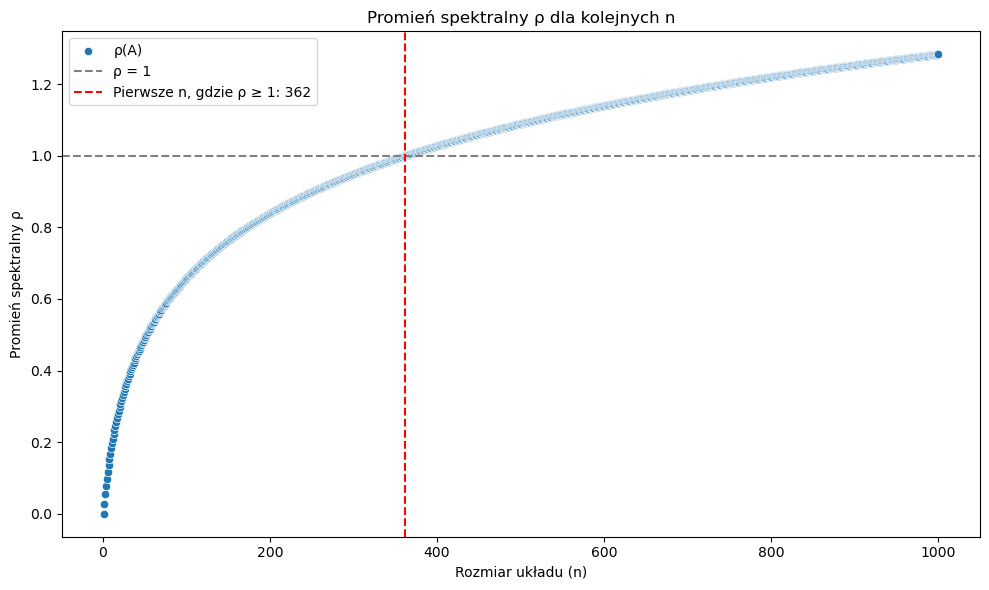

In [ ]:
df_rho = pd.read_csv('rhos.csv')

mask_not_conv = df_rho['rho'] >= 1.0
if mask_not_conv.any():
    n_first_not_conv = int(df_rho[mask_not_conv].iloc[0]['n'])
else:
    n_first_not_conv = None

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_rho, x='n', y='rho', marker='o', label='ρ(A)')

plt.axhline(1.0, color='gray', linestyle='--', label='ρ = 1')

if n_first_not_conv is not None:
    plt.axvline(
        n_first_not_conv,
        color='red',
        linestyle='--',
        label=f'Pierwsze n, gdzie ρ ≥ 1: {n_first_not_conv}'
    )

plt.xlabel('Rozmiar układu (n)')
plt.ylabel('Promień spektralny ρ')
plt.title('Promień spektralny ρ dla kolejnych n')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
x0_map = {
    'zero':    'wektor zerowy',
    'rand100': 'wektor oddalony',
    'rand_mid':'wektor pośredni'
}
crit_map = {
    'diff': 'kryterium przyrostowe',
    'res':  'kryterium rezydualne'
}

def _draw_heatmap(pivot_df, metric_name, title, fmt, logscale, fname):
    data = pivot_df.astype(float).replace([np.inf, -np.inf], np.nan)
    if data.isna().all().all():
        print(f"[{title}] – wszystkie wartości NaN, pomijam.")
        return

    if logscale:
        positive_vals = data.where((data > 0) & np.isfinite(data)).stack()
        if positive_vals.empty:
            print(f"[{title}] – brak dodatnich wartości do logscale, pomijam.")
            return
        vmin, vmax = positive_vals.min(), positive_vals.max()
        norm = LogNorm(vmin=vmin, vmax=vmax)
    else:
        norm = None

    plt.figure(figsize=(12, 8))
    sns.heatmap(
        data,
        cmap='Spectral_r',
        annot=True,
        fmt=fmt,
        norm=norm,
        linewidths=0.5,
        linecolor='white',
        cbar_kws={'label': metric_name} if logscale else {}
    )
    plt.xlabel('Dokładność zera')
    plt.ylabel('Rozmiar układu')
    plt.title(title, y=1.02, fontsize=16)
    plt.tight_layout()

    plt.savefig(fname, dpi=300)
    plt.close()


def generate_heatmaps(df_zero, df_rand100, df_mid, criterion):
    short_map = {
        'zero':    'zero',
        'rand100': 'rand100',
        'rand_mid':'mid'
    }

    data_map = {
        'zero':     df_zero,
        'rand100':  df_rand100,
        'rand_mid': df_mid
    }

    for x0_name, df in data_map.items():
        polski_x0 = x0_map[x0_name]
        polski_crit = crit_map.get(criterion, criterion)
        short_x0 = short_map[x0_name]

        df_filt = df[(df['x0_name'] == x0_name) & (df['criterion'] == criterion)].copy()
        if df_filt.empty:
            print(f"[{polski_x0}] Brak danych dla {polski_crit}.")
            continue

        unique_tols = sorted(df_filt['tol'].unique(), reverse=True)
        df_filt['tol'] = pd.Categorical(df_filt['tol'],
                                        categories=unique_tols,
                                        ordered=True)

        # 1) Heatmapa liczby iteracji (iters)
        pivot_iters = df_filt.pivot_table(
            index='n', columns='tol', values='iters', aggfunc='mean'
        )
        _draw_heatmap(
            pivot_iters,
            metric_name='Liczba iteracji',
            title=f"Liczba iteracji ({polski_x0}, {polski_crit})",
            fmt='.0f',
            logscale=False,
            fname=f"heatmap_iters_{short_x0}_{criterion}.png"
        )

        # 2) Heatmapa średniego czasu na iterację (avg_time_iter)
        pivot_time = df_filt.pivot_table(
            index='n', columns='tol', values='avg_time_iter', aggfunc='mean'
        )
        _draw_heatmap(
            pivot_time,
            metric_name='Średni czas na iterację [s]',
            title=f"Średni czas na iterację ({polski_x0}, {polski_crit})",
            fmt='.2e',
            logscale=True,
            fname=f"heatmap_time_{short_x0}_{criterion}.png"
        )

        # 3) Heatmapa błędu maksimum (err_inf)
        pivot_err_inf = df_filt.pivot_table(
            index='n', columns='tol', values='err_inf', aggfunc='mean'
        )
        _draw_heatmap(
            pivot_err_inf,
            metric_name='Błąd maksimum',
            title=f"Błąd maksimum ({polski_x0}, {polski_crit})",
            fmt='.2e',
            logscale=True,
            fname=f"heatmap_errinf_{short_x0}_{criterion}.png"
        )

        # 4) Heatmapa błędu euklidesowego (err2)
        pivot_err2 = df_filt.pivot_table(
            index='n', columns='tol', values='err2', aggfunc='mean'
        )
        _draw_heatmap(
            pivot_err2,
            metric_name='Błąd euklidesowy',
            title=f"Błąd euklidesowy ({polski_x0}, {polski_crit})",
            fmt='.2e',
            logscale=True,
            fname=f"heatmap_erreuk_{short_x0}_{criterion}.png"
        )


In [73]:
df_zero    = pd.read_csv('jacobi_zero.csv')
df_rand100 = pd.read_csv('jacobi_rand100.csv')
df_mid     = pd.read_csv('jacobi_rand_mid.csv')

generate_heatmaps(df_zero, df_rand100, df_mid, 'diff')  # kryterium przyrostowe
generate_heatmaps(df_zero, df_rand100, df_mid, 'res')   # kryterium residualne

C:\Users\Maciek\AppData\Local\Temp\ipykernel_29196\84342198.py:80: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_iters = df_filt.pivot_table(
C:\Users\Maciek\AppData\Local\Temp\ipykernel_29196\84342198.py:93: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_time = df_filt.pivot_table(
C:\Users\Maciek\AppData\Local\Temp\ipykernel_29196\84342198.py:106: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_err_inf = df_filt.pivot_table(
C:\Users\Maciek\AppData\Local\Temp\ipykernel_29196\84342198.py